In [226]:
import requests
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')

In [24]:
# get historcal with basic data
# response = requests.get("https://api.llama.fi/protocol/uniswap")
# print(response.status_code)
# print(response.json())

200
{'id': '1', 'name': 'Uniswap', 'address': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'symbol': 'UNI', 'url': 'https://info.uniswap.org/', 'description': 'A fully decentralized protocol for automated liquidity provision on Ethereum.\r\n', 'chain': 'Ethereum', 'logo': 'https://icons.llama.fi/uniswap.png', 'audits': '2', 'audit_note': None, 'gecko_id': 'uniswap', 'cmcId': '7083', 'category': 'Dexes', 'chains': ['Optimism', 'Ethereum', 'Arbitrum'], 'module': 'uniswap/index.js', 'twitter': 'Uniswap', 'audit_links': ['https://github.com/Uniswap/uniswap-v3-core/tree/main/audits', 'https://github.com/Uniswap/uniswap-v3-periphery/tree/main/audits', 'https://github.com/ConsenSys/Uniswap-audit-report-2018-12'], 'oracles': ['Uniswap'], 'methodology': "Counts the tokens locked on AMM pools, pulling the data from the 'ianlapham/uniswapv2' subgraph", 'misrepresentedTokens': True, 'hallmarks': [[1598412107, 'SushiSwap launch'], [1599535307, 'SushiSwap migration'], [1600226507, 'LM starts'], [16

In [446]:
# get protocol tvl 
response = requests.get("https://api.llama.fi/protocols")
output = response.json()

# market dataframe
df_market = pd.DataFrame(output)
market_list = pd.read_csv("protocols_list.csv")
df_market = df_market[df_market['slug'].isin(market_list['slug'])]
df_market = df_market[['chain', 'category', 'tvl', 'change_1h', 'change_1d', 'change_7d', 'mcap']]

# chainlink dataframe
df_chainlink = pd.DataFrame(output)
chainlink_list = pd.read_csv("chainlink_users_list.csv")
df_chainlink = df_chainlink[df_chainlink['slug'].isin(chainlink_list['slug'])]
df_chainlink = df_chainlink[['chain', 'category', 'tvl', 'change_1h', 'change_1d', 'change_7d', 'mcap']]

In [447]:
df_market = df_market[df_market['chain'].notna()]
df_market_og = df_market[df_market['category'].notna()]
df_chainlink = df_chainlink[df_chainlink['chain'].notna()]
df_chainlink_og = df_chainlink[df_chainlink['category'].notna()]

df_chainlink = df_chainlink_og.fillna(0) 
df_market = df_market_og.fillna(0) 
# Depending on the analysis, the values may either have the NaN values replaced with 0 or filered out.
# I.e. in the case of the tvl by category, chain and the net percentage replacing NaN values with 0 is fine as those values would have a weight of 0 in the aggregation/filter
# However with the TVL/Marketcap metric, replacing market caps with 0 would give a heavy weighting to the tvl thus NaN values are filtered out instead. 

In [448]:
# get count statistics by chain
df_market_chain_count = df_market.groupby(['chain']).size().reset_index(name='Market').set_index('chain')
df_chainlink_chain_count = df_chainlink.groupby(['chain']).size().reset_index(name='Chainlink').set_index('chain')

# get sum tvl statistics by chain
## tvl weighted change (not super accurate but can gauge some change)
df_market['change_1h'] = (df_market['change_1h']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market['change_1d'] = (df_market['change_1d']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market['change_7d'] = (df_market['change_7d']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market_chain_sum = df_market.groupby(['chain']).sum().reset_index().set_index('chain')
df_market_chain_sum.columns = ['tvl', 'net_change_1h', 'net_change_1d', 'net_change_7d', 'mcap']
df_chainlink['change_1h'] = df_chainlink['change_1h']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink['change_1d'] = df_chainlink['change_1d']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink['change_7d'] = df_chainlink['change_7d']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink_chain_sum = df_chainlink.groupby(['chain']).sum().reset_index().set_index('chain')
df_chainlink_chain_sum.columns = ['tvl', 'net_change_1h', 'net_change_1d', 'net_change_7d', 'mcap']

# get count statistics by category
df_market_category_count = df_market.groupby(['category']).size().reset_index(name='Market').set_index('category')
df_chainlink_category_count = df_chainlink.groupby(['category']).size().reset_index(name='Chainlink').set_index('category')

# get sum tvl statistics by category
## tvl weighted change
df_market_category_sum = df_market.groupby(['category']).sum().reset_index().set_index('category')
df_market_category_sum.columns = ['tvl', 'net_change_1h', 'net_change_1d', 'net_change_7d', 'mcap']
df_chainlink_category_sum = df_chainlink.groupby(['category']).sum().reset_index().set_index('category')
df_chainlink_category_sum.columns = ['tvl', 'net_change_1h', 'net_change_1d', 'net_change_7d', 'mcap']

# average tvl to market cap 

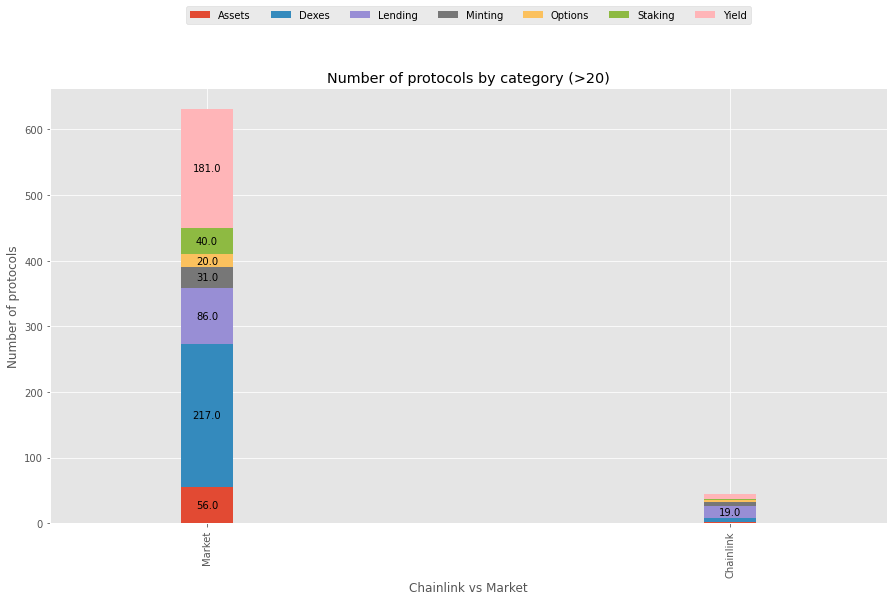

In [211]:
# plot count statistics by category
union = pd.concat([df_market_category_count.transpose(), df_chainlink_category_count.transpose()],axis=0)
union = union.loc[:, (union.sum() >= 20)] #too many categories, only plotting the largest
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Number of protocols')
plt.title('Number of protocols by category (>20)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

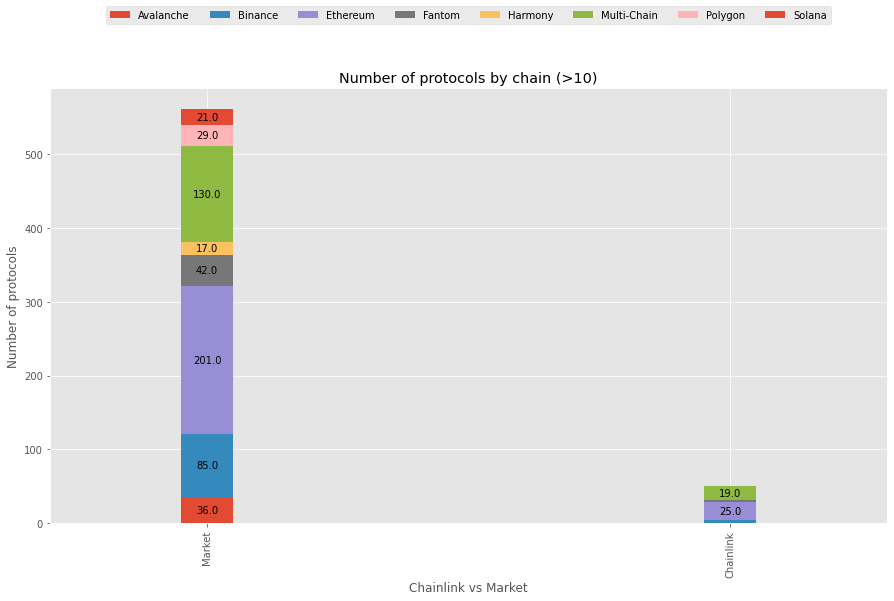

In [212]:
# plot count statistics by chain
union = pd.concat([df_market_chain_count.transpose(), df_chainlink_chain_count.transpose()],axis=0)
union = union.loc[:, (union.sum() >= 15)] #too many categories, only plotting the largest
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Number of protocols')
plt.title('Number of protocols by chain (>10)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

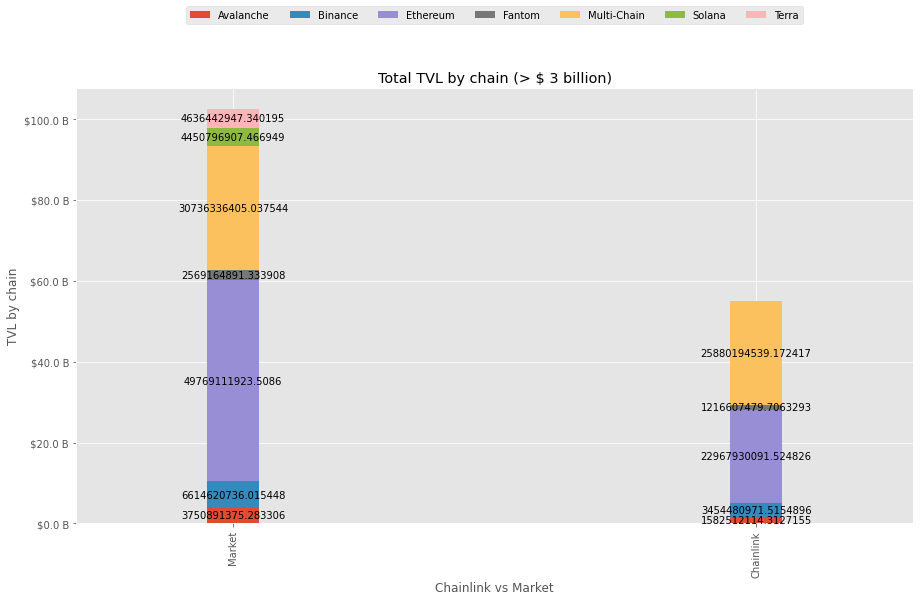

In [393]:
# plot sum statistics by chain
union = pd.concat([df_market_chain_sum[['tvl']].transpose(), df_chainlink_chain_sum[[ 'tvl']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 3000000000)] #too many categories, only plotting the largest
union.index = ['Market', 'Chainlink']
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
def millions_formatter(x, pos):
    return f'${x / 1000000000} B'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL by chain')
plt.title('Total TVL by chain (> $ 3 billion)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

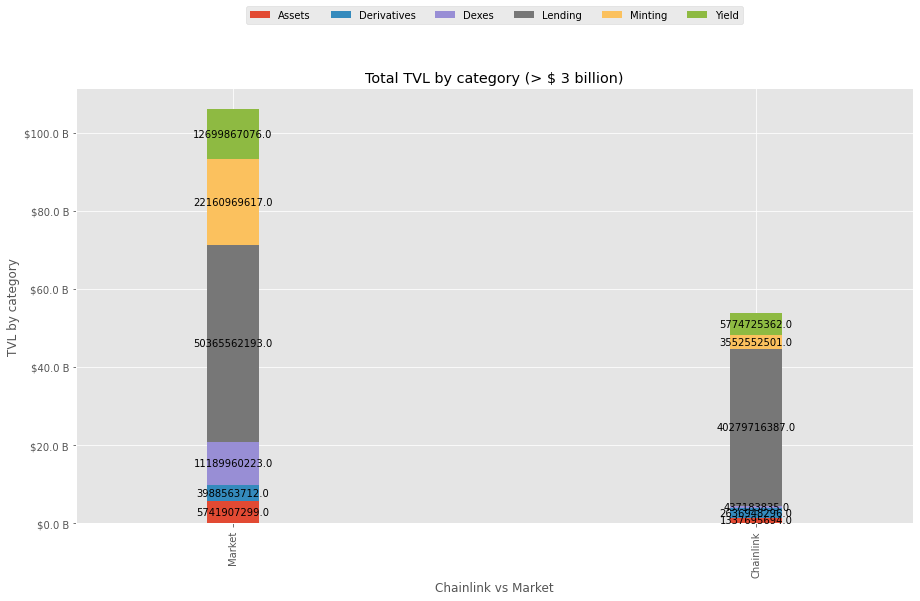

In [240]:
# plot sum statistics by category
union = pd.concat([df_market_category_sum[['tvl']].transpose(), df_chainlink_category_sum[['tvl']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 3000000000)] #too many categories, only plotting the largest
union.index = ['Market', 'Chainlink']
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
def millions_formatter(x, pos):
    return f'${x / 1000000000} B'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL by category')
plt.title('Total TVL by category (> $ 3 billion)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

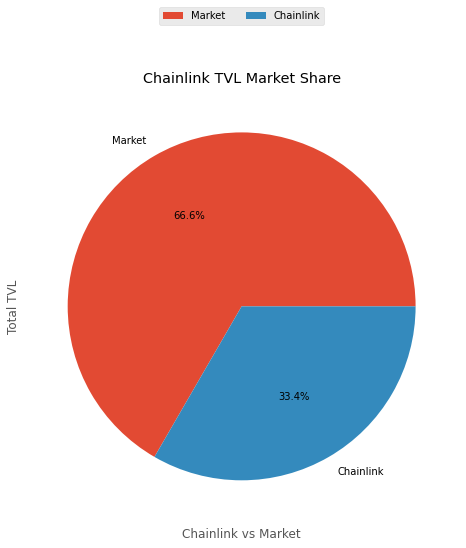

In [299]:
# plot tvl captured 
df_chainlink_total_sum = df_chainlink_chain_sum.sum(axis=0).reset_index(name='Chainlink').transpose()
df_chainlink_total_sum.columns = df_chainlink_total_sum.iloc[0]
df_chainlink_total_sum = df_chainlink_total_sum.iloc[1:,:]
df_market_total_sum = df_market_chain_sum.sum(axis=0).reset_index(name='Market').transpose()
df_market_total_sum.columns = df_market_total_sum.iloc[0]
df_market_total_sum = df_market_total_sum.iloc[1:,:]
union = pd.concat([df_market_total_sum['tvl'], df_chainlink_total_sum['tvl']],axis=0)

ax = union.plot.pie(subplots=True, figsize= (15,8), autopct='%1.1f%%')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Total TVL')
plt.title('Chainlink TVL Market Share')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

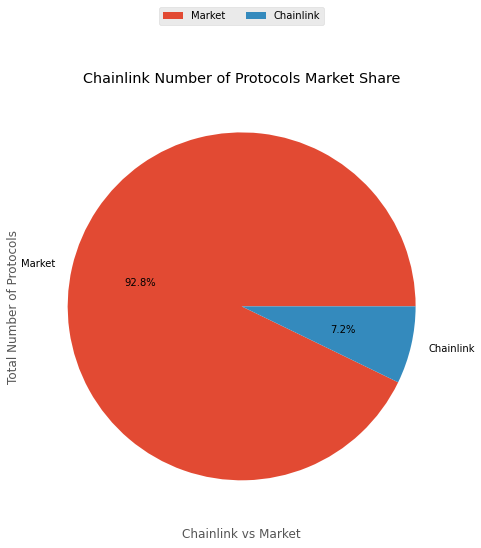

In [311]:
# plot number of protocols captured 
df_chainlink_total_count = df_chainlink_chain_count.sum(axis=0).reset_index(name='Chainlink').transpose()
df_chainlink_total_count.columns = df_chainlink_total_count.iloc[0]
df_chainlink_total_count = df_chainlink_total_count.iloc[1:,:]
df_chainlink_total_count.columns = ['count']
df_market_total_count = df_market_chain_count.sum(axis=0).reset_index(name='Market').transpose()
df_market_total_count.columns = df_market_total_count.iloc[0]
df_market_total_count = df_market_total_count.iloc[1:,:]
df_market_total_count.columns = ['count']
union = pd.concat([df_market_total_count, df_chainlink_total_count],axis=0)

ax = union.plot.pie(subplots=True, figsize= (15,8), autopct='%1.1f%%')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Total Number of Protocols')
plt.title('Chainlink Number of Protocols Market Share')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

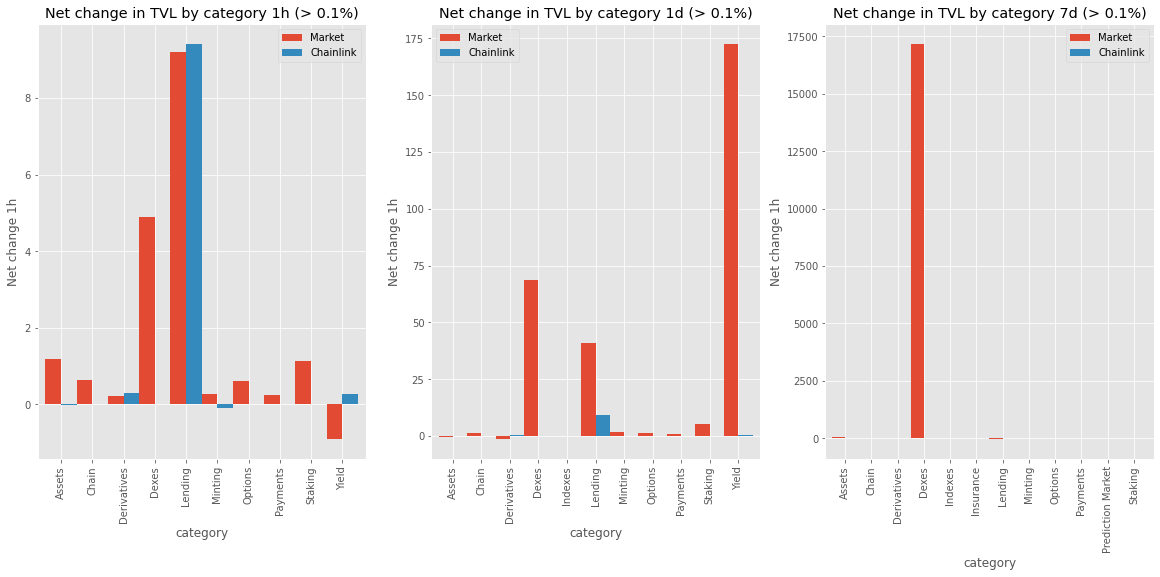

In [464]:
# Net change 1hr, 1d, 7d by category
union1 = pd.concat([df_market_category_sum[['net_change_1h']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union1 = union1.loc[:, (union1.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union1.index = ['Market', 'Chainlink']
union1 = union1.transpose()

union2 = pd.concat([df_market_category_sum[['net_change_1d']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union2 = union2.loc[:, (union2.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union2.index = ['Market', 'Chainlink']
union2 = union2.transpose()

union3 = pd.concat([df_market_category_sum[['net_change_7d']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union3 = union3.loc[:, (union3.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union3.index = ['Market', 'Chainlink']
union3 = union3.transpose()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey= False, figsize= (20,8))
ax1 = union1.plot.bar(width = 1, ax=ax1)
union2.plot.bar(width = 1, ax=ax2)
union3.plot.bar(width = 1, ax=ax3)
ax1.set_ylabel('Net change 1h')
ax2.set_ylabel('Net change 1h')
ax3.set_ylabel('Net change 1h')
ax1.set_title('Net change in TVL by category 1h (> 0.1%)')
ax2.set_title('Net change in TVL by category 1d (> 0.1%)')
ax3.set_title('Net change in TVL by category 7d (> 0.1%)')
plt.show()

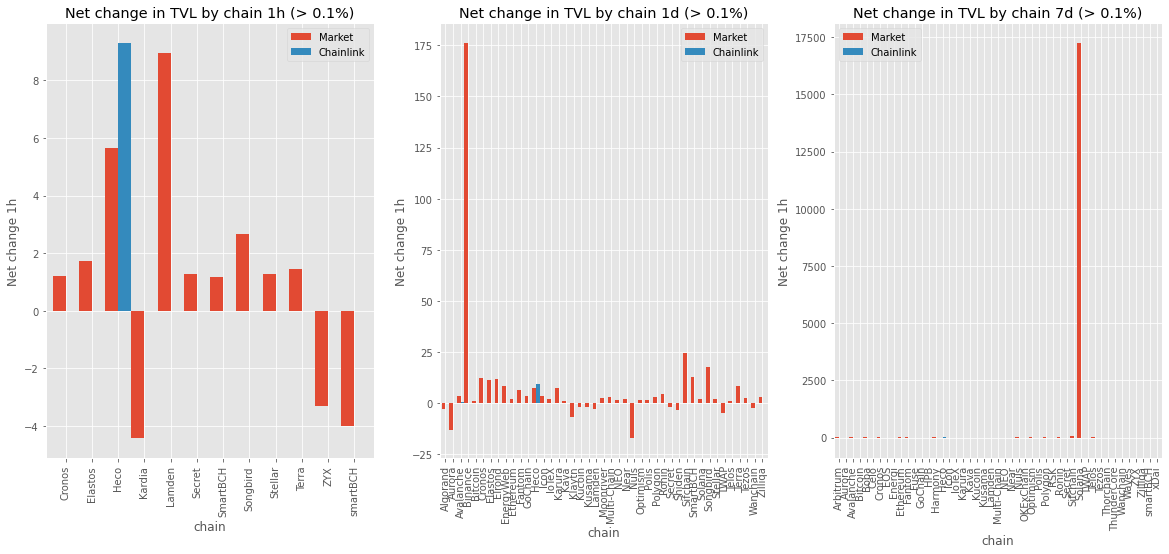

In [487]:
# Net change 1hr by chain
union1 = pd.concat([df_market_chain_sum[['net_change_1h']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union1 = union1.loc[:, (union1.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union1.index = ['Market', 'Chainlink']
union1 = union1.transpose()

union2 = pd.concat([df_market_chain_sum[['net_change_1d']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union2 = union2.loc[:, (union2.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union2.index = ['Market', 'Chainlink']
union2 = union2.transpose()

union3 = pd.concat([df_market_chain_sum[['net_change_7d']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union3 = union3.loc[:, (union3.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union3.index = ['Market', 'Chainlink']
union3 = union3.transpose()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey= False, figsize= (20,8))
ax1 = union1.plot.bar(width = 1, ax=ax1)
union2.plot.bar(width = 1, ax=ax2)
union3.plot.bar(width = 1, ax=ax3)
ax1.set_ylabel('Net change 1h')
ax2.set_ylabel('Net change 1h')
ax3.set_ylabel('Net change 1h')
ax1.set_title('Net change in TVL by chain 1h (> 1%)')
ax2.set_title('Net change in TVL by chain 1d (> 1%)')
ax3.set_title('Net change in TVL by chain 7d (> 1%)')
plt.show()

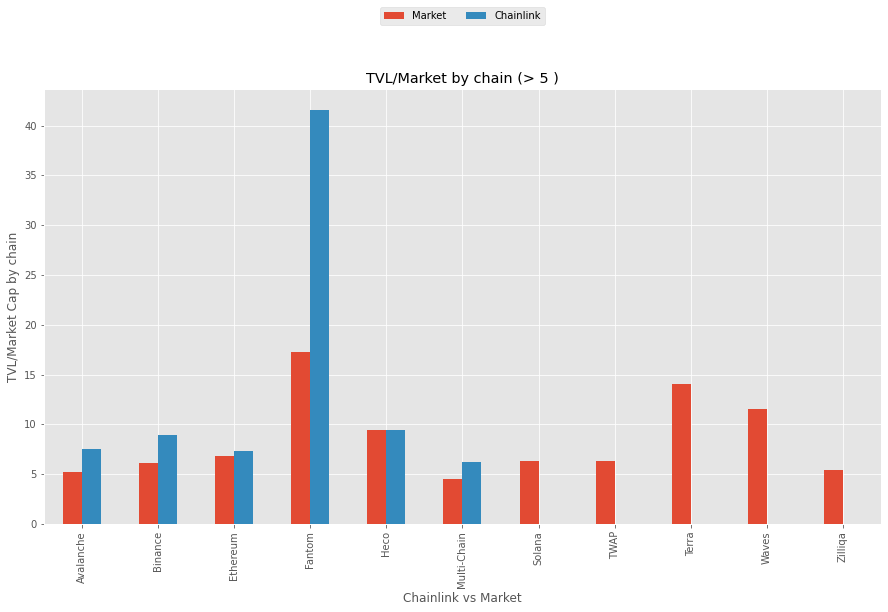

In [498]:
# tvl market cap analysis uses the og data set without the 0 replacing na
df_market_market_cap =  df_market_og.dropna()
df_chainlink_market_cap =  df_chainlink_og.dropna()
df_market_market_cap = df_market_market_cap[df_market_market_cap['mcap'] != 0] 
df_chainlink_market_cap = df_chainlink_market_cap[df_chainlink_market_cap['mcap'] != 0] 
df_market_market_cap['tvl_over_mcap'] = df_market_market_cap['tvl']/df_market_market_cap['mcap']
df_chainlink_market_cap['tvl_over_mcap'] = df_chainlink_market_cap['tvl']/df_chainlink_market_cap['mcap']

df_market_average_market_cap = df_market_market_cap.groupby(['chain'])['tvl_over_mcap'].mean().reset_index().set_index('chain')
df_chainlink_average_market_cap = df_chainlink_market_cap.groupby(['chain'])['tvl_over_mcap'].mean().reset_index().set_index('chain')
df_market_average_market_cap.columns = ['average_tvl_over_mcap']
df_chainlink_average_market_cap.columns = ['average_tvl_over_mcap']

union = pd.concat([df_market_average_market_cap[['average_tvl_over_mcap']].transpose(), df_chainlink_average_market_cap[['average_tvl_over_mcap']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 5)] #too many categories, only plotting the largest percentage shifts
union.index = ['Market', 'Chainlink']
union = union.transpose()

ax = union.plot.bar(width = 0.5, figsize= (15,8))
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL/Market Cap by chain')
plt.title('TVL/Market by chain (> 5 )')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

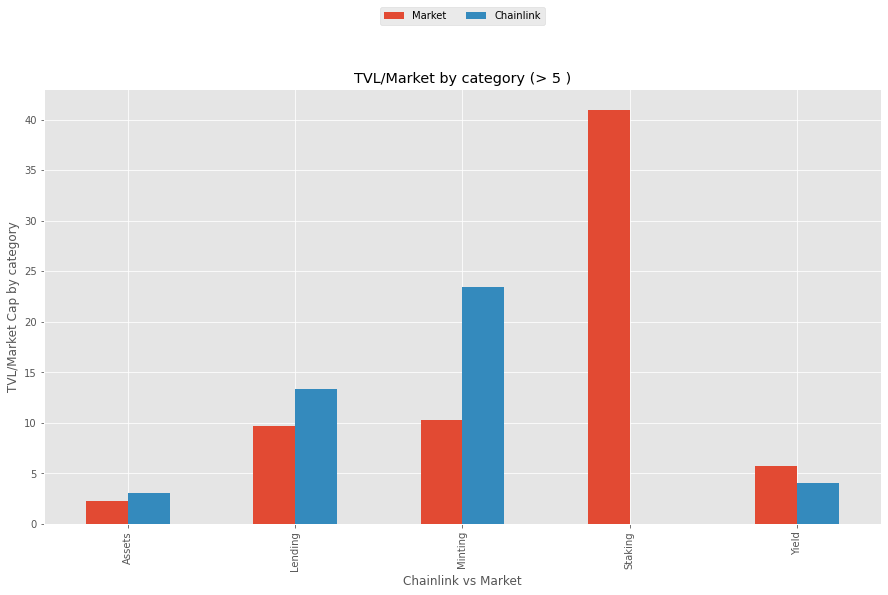

In [495]:
df_market_average_market_cap = df_market_market_cap.groupby(['category'])['tvl_over_mcap'].mean().reset_index().set_index('category')
df_chainlink_average_market_cap = df_chainlink_market_cap.groupby(['category'])['tvl_over_mcap'].mean().reset_index().set_index('category')
df_market_average_market_cap.columns = ['average_tvl_over_mcap']
df_chainlink_average_market_cap.columns = ['average_tvl_over_mcap']

union = pd.concat([df_market_average_market_cap[['average_tvl_over_mcap']].transpose(), df_chainlink_average_market_cap[['average_tvl_over_mcap']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 5)] #too many categories, only plotting the largest percentage shifts
union.index = ['Market', 'Chainlink']
union = union.transpose()

ax = union.plot.bar(width = 0.5, figsize= (15,8))
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL/Market Cap by category')
plt.title('TVL/Market by category (> 5 )')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()